In [1]:
import scipy.io as scio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

Animate from the data

In [2]:
data_path = r"C:\\Users\\onurb\\master\\PRJ_4ID22_TP\\Transolver\\PDE-Solving-StandardBenchmark\\data\\fno\\NavierStokes_V1e-5_N1200_T20\\NavierStokes_V1e-5_N1200_T20.mat"
data = scio.loadmat(data_path)
data = data['u'] #get the velocity component
print(data.shape)

s = 300 #simulation number

test_data = data[s, :, :, :20] # 64, 64, 20

(1200, 64, 64, 20)


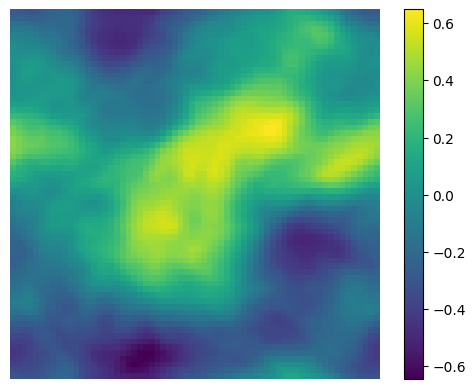

In [3]:


fig, ax = plt.subplots()
cax = ax.imshow(data[s, :, :, 0].reshape(64, 64), cmap='viridis')
ax.axis('off')

# Add colorbar
cbar = plt.colorbar(cax, ax=ax)

# Animation function
def update(frame):
    f = np.flip(data[s, :, :, frame].reshape(64, 64), 1)
    #f = data[s, :, :, frame].reshape(64, 64)
    cax.set_array(f)
    return [cax]

# Create animation
ani = animation.FuncAnimation(fig, update, frames=range(0,20), interval=200, blit=False)

ani.save("animation.gif", writer="pillow", fps=10)

#plt.imshow(data[s, :, :, 9].reshape(64, 64), cmap='coolwarm')

#plt.show()

Predict from a model

In [4]:
#load model
from phi.flow import *
import numpy as np
from phi.field import curl
from tqdm.notebook import trange
import matplotlib.pyplot as plt
from SequenSolver import SequenSolver
import torch

save_name = "tokenizer_ep10_sim10_2"

transolver_path = "C:\\Users\\onurb\\master\\PRJ_4ID22_TP\\codes\\Transolver\\model_weights\\encoder_ep20_head_1.pt"
model = SequenSolver(transolver_path, T=10, H=64, W=64, M=16, C=32, B=1, layers=8).cuda()

model.load_state_dict(torch.load("./sequential_checkpoints/" + save_name + ".pt", weights_only=True), strict=False)
model.eval()

slice_learner_path = "C:\\Users\\onurb\\master\\PRJ_4ID22_TP\\Transolver\\PDE-Solving-StandardBenchmark\\sequential_checkpoints\\buff.pt"
#slice_learner_path = "C:\\Users\\onurb\\master\\PRJ_4ID22_TP\\Transolver\\PDE-Solving-StandardBenchmark\\sequential_checkpoints\\slice_ep1_sim20_unified_vort.pt"

c:\Users\onurb\anaconda3\envs\cuda\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [5]:
def get_grid(batchsize=1):
        size_x, size_y = 64, 64
        ref = 8
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        grid = torch.cat((gridx, gridy), dim=-1).cuda()  # B H W 2

        gridx = torch.tensor(np.linspace(0, 1, ref), dtype=torch.float)
        gridx = gridx.reshape(1, ref, 1, 1).repeat([batchsize, 1, ref, 1])
        gridy = torch.tensor(np.linspace(0, 1, ref), dtype=torch.float)
        gridy = gridy.reshape(1, 1, ref, 1).repeat([batchsize, ref, 1, 1])
        grid_ref = torch.cat((gridx, gridy), dim=-1).cuda()  # B H W 8 8 2

        pos = torch.sqrt(torch.sum((grid[:, :, :, None, None, :] - grid_ref[:, None, None, :, :, :]) ** 2, dim=-1)). \
            reshape(batchsize, size_x, size_y, ref * ref).contiguous()
        
        return pos   

torch.Size([1, 4096, 64])
tensor(274.0106, device='cuda:0', grad_fn=<SumBackward0>)
tensor(1090.4675, device='cuda:0', grad_fn=<SumBackward0>)
tensor(2653.2034, device='cuda:0', grad_fn=<SumBackward0>)
tensor(4515.4590, device='cuda:0', grad_fn=<SumBackward0>)
tensor(6325.7744, device='cuda:0', grad_fn=<SumBackward0>)
tensor(8611.1465, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10239.5439, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10509.2871, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10686.8740, device='cuda:0', grad_fn=<SumBackward0>)
tensor(11361.5439, device='cuda:0', grad_fn=<SumBackward0>)


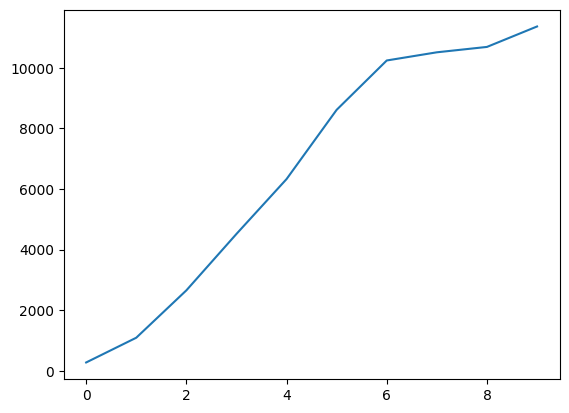

In [6]:
#define positional information
h = 64
x = np.linspace(0, 1, h)
y = np.linspace(0, 1, h)
x, y = np.meshgrid(x, y)
pos = np.c_[x.ravel(), y.ravel()]
pos = torch.tensor(pos, dtype=torch.float).unsqueeze(0).cuda()
uni_grid = get_grid()
pos=uni_grid.repeat(pos.shape[0], 1, 1, 1).reshape(pos.shape[0], 64 * 64, 8 * 8)
print(pos.shape)

#predict next frames to get a simulation
test = test_data.reshape(1, -1, test_data.shape[-1]) #1, 4096, 40
test = torch.from_numpy(test)

#from frame 5 to 20, the field contains x and y field so step = 2
yy = test[..., 10:20]
fx = test[...,:10].cuda()

sim_pred = []

step = 1

losses = []

for t in range(0,10,step):
    y = yy[..., t:t + step].cuda()
    pred = model.solve_with_slice_learner(slice_learner_path, pos, fx, y, unified_pos=1, use_vorticity=1, use_previous_slice = True)

    loss = torch.sum(torch.pow(pred.reshape(1, -1) - y.reshape(1, -1),2))
    losses.append(loss.detach().item())

    print(loss)

    vort = pred[0,:,0]

    vort = vort.reshape(64,64)

    # Convert to PhiFlow tensors
    vort = tensor(vort, spatial('x,y'))

    # Create a StaggeredGrid for the velocity field
    f = CenteredGrid(math.tensor(vort), extrapolation.PERIODIC)

    sim_pred.append(f)

    #update fx
    fx = torch.cat((fx[..., step:], pred), dim=-1)

c_trj_pred = phi.field.stack(sim_pred, batch('time'))

plt.plot(losses)

In [7]:
print(sum(losses))

66267.31042480469


In [8]:
plot(c_trj_pred, animate='time', frame_time=120, overlay='args')